# Lesson 3: Radiometric Response

**Description:** This tutorial demonstrates how to use Blender as a controlled simulation environment to recover the radiometric response function of a virtual camera.  This is a key step in many computational photography and vision workflows, such as high dynamic range (HDR) imaging or photometric calibration.

In real-world imaging, a camera’s sensor maps incoming light intensities to digital values, often via a non-linear function. By simulating this process in Blender, we can generate synthetic images under controlled illumination and camera settings, then use these images to estimate the response curve from first principles.

**Requirement(s):** None

**Author:** Matthew O'Toole

---

In [3]:
import bpy
import bmesh
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

from L001_hello_world import get_render, clear_scene

# Clear scene
if __name__ == '__main__':
    clear_scene()

#### Part 1: Initialize the scene

This section programmatically constructs a simple scene, including a camera, a point light source, and a plane.

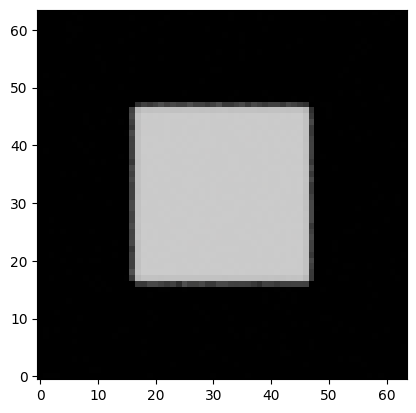

In [4]:
if __name__ == '__main__':
    # Set render engine and resolution for ray tracing
    bpy.context.scene.render.engine = 'CYCLES'
    bpy.context.scene.render.resolution_x = 64
    bpy.context.scene.render.resolution_y = 64
    bpy.context.scene.render.image_settings.file_format = 'PNG'

    # Do not reduce number of samples per pixel based on render noise
    bpy.context.scene.cycles.use_adaptive_sampling = False 

    # Set number of samples to render at each pixel
    bpy.context.scene.cycles.samples = 100

    # Do not denoise the rendered image
    bpy.context.scene.cycles.use_denoising = False


    # Create camera
    bpy.ops.object.camera_add(rotation=(np.pi/2, 0, 0))
    cam = bpy.context.active_object
    bpy.context.scene.camera = cam

    # Add emissive material
    emissive_material = bpy.data.materials.new(name='Emissive Material')
    emissive_material.use_nodes = True
    bsdf = emissive_material.node_tree.nodes['Principled BSDF']
    bsdf.inputs['Emission Strength'].default_value = 1.2

    # Add plane to scene
    bpy.ops.mesh.primitive_plane_add(location=(0, 6, 0), 
                                     rotation=(np.pi/2, 0, 0))
    plane = bpy.context.active_object
    plane.data.materials.append(emissive_material)
    

    # Render scene
    plt.imshow(get_render(), origin='lower')

#### Part 2: Function for estimating the radiometric response

The following function, `radiometric_response()` estimates the radiometric response function of a virtual camera by analyzing a set of rendered images taken at different exposure levels. This function renders the image 50 times at exposure values uniformly distributed between 0 and 1, and outputs two arrays for the exposures and corresponding pixel values.


In [5]:
def radiometric_response():
    N = 50
    pixel_values = []
    exposure_values = np.linspace(0,1,N)

    # Render and display image
    for itr in range(len(exposure_values)):
        # Adjust the film exposure scales the incident radiance values
        bpy.context.scene.cycles.film_exposure = exposure_values[itr]
        
        # Render the scene
        pixels = get_render()
        width, height, _ = pixels.shape

        # Keep track of the pixel value at the center of the image
        pixel_values.append(pixels[height//2, width//2, 0])

    return exposure_values, pixel_values

#### Part 3: Compute the radiometric response for different tone mapping transforms

When rendering and saving images (in PNG format), Blender uses a tone mapping transform to process the raw pixel values.  There are multiple options to pick from, including *Standard*, *AgX*, and *Raw*.

The following function cycles through different tone mapping functions, computes the radiometric response, and plots the result.  Note the linear response of *Raw* (i.e., no tone mapping), but saturates for pixel values above 1.

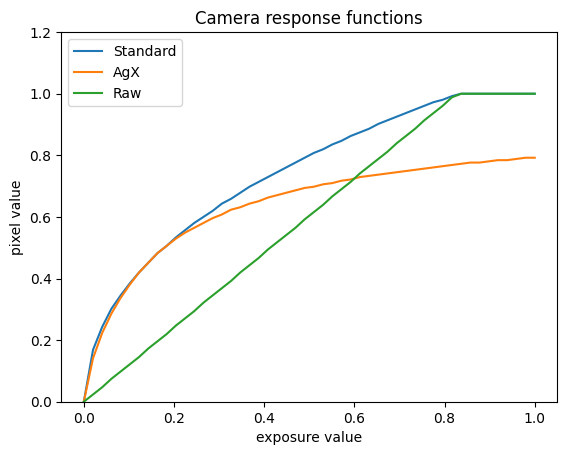

In [6]:
def test_view_transforms(labels):
    for itr in range(len(labels)):
        bpy.context.scene.view_settings.view_transform = labels[itr]
        x, y = radiometric_response()
        plt.plot(x, y, label=labels[itr])

    plt.xlabel('exposure value')
    plt.ylabel('pixel value')
    plt.title('Camera response functions')
    plt.legend()
    plt.ylim(0, 1.2);
    plt.show()

if __name__ == '__main__':
    labels = ['Standard', 'AgX', 'Raw']
    bpy.context.scene.render.image_settings.file_format = 'PNG'
    
    test_view_transforms(labels)

#### Part 4: Compute the radiometric response for HDR format

It is often desirable to render high-dynamic range images (HDR) that both (i) have a linear response function and (ii) does not saturate.  For example, the *HDR* file format encodes pixel values as a floating point number.  Note that the response function is linear when saving HDR images.

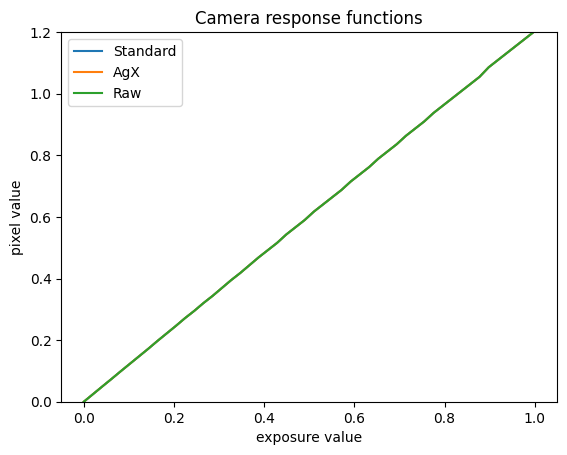

In [7]:
if __name__ == '__main__':
    labels = ['Standard', 'AgX', 'Raw']
    bpy.context.scene.render.image_settings.file_format = 'HDR'
    test_view_transforms(labels)

#### Exercise 1: Experiment with gamma and exposure

#### Exercise 2: Custom tone mapping function

#### Exercise 3: Applying the inverse tone mapping function